**Executed:** Sat Mar 25 17:54:46 2017

**Duration:** 9 seconds.

# usALEX-5samples - Template

> *This notebook is executed through [8-spots paper analysis](8-spots paper analysis.ipynb).*
> *For a direct execution, uncomment the cell below.*

In [1]:
ph_sel_name = "None"

In [2]:
data_id = "17d"

In [3]:
# data_id = "7d"

## Load software and filenames definitions

In [4]:
from fretbursts import *

 - Optimized (cython) burst search loaded.
 - Optimized (cython) photon counting loaded.


--------------------------------------------------------------
 You are running FRETBursts (version 0.5.9).

 If you use this software please cite the following paper:

   FRETBursts: An Open Source Toolkit for Analysis of Freely-Diffusing Single-Molecule FRET
   Ingargiola et al. (2016). http://dx.doi.org/10.1371/journal.pone.0160716 

--------------------------------------------------------------


In [5]:
init_notebook()
from IPython.display import display

Data folder:

In [6]:
data_dir = './data/singlespot/'

In [7]:
import os
data_dir = os.path.abspath(data_dir) + '/'
assert os.path.exists(data_dir), "Path '%s' does not exist." % data_dir

List of data files:

In [8]:
from glob import glob
file_list = sorted(f for f in glob(data_dir + '*.hdf5') if '_BKG' not in f)
## Selection for POLIMI 2012-11-26 datatset
labels = ['17d', '27d', '7d', '12d', '22d']
files_dict = {lab: fname for lab, fname in zip(labels, file_list)}
files_dict

{'12d': '/Users/anto/Google Drive/notebooks/multispot_paper/data/singlespot/007_dsDNA_12d_3nM_green100u_red40u.hdf5',
 '17d': '/Users/anto/Google Drive/notebooks/multispot_paper/data/singlespot/004_dsDNA_17d_green100u_red40u.hdf5',
 '22d': '/Users/anto/Google Drive/notebooks/multispot_paper/data/singlespot/008_dsDNA_22d_500pM_green100u_red40u.hdf5',
 '27d': '/Users/anto/Google Drive/notebooks/multispot_paper/data/singlespot/005_dsDNA_27d_green100u_red40u.hdf5',
 '7d': '/Users/anto/Google Drive/notebooks/multispot_paper/data/singlespot/006_dsDNA_7d_green100u_red40u.hdf5'}

In [9]:
data_id

'17d'

## Data load

Initial loading of the data:

In [10]:
d = loader.photon_hdf5(filename=files_dict[data_id])

Load the **leakage coefficient** from disk:

In [11]:
leakage_coeff_fname = 'results/usALEX - leakage coefficient DexDem.csv'
leakage = np.loadtxt(leakage_coeff_fname)

print('Leakage coefficient:', leakage)

Leakage coefficient: 0.10029


Load the **direct excitation coefficient** ($d_{exAA}$) from disk:

In [12]:
dir_ex_coeff_fname = 'results/usALEX - direct excitation coefficient dir_ex_aa.csv'
dir_ex_aa = np.loadtxt(dir_ex_coeff_fname)

print('Direct excitation coefficient (dir_ex_aa):', dir_ex_aa)

Direct excitation coefficient (dir_ex_aa): 0.06062


Update `d` with the correction coefficients:

In [13]:
d.leakage = leakage
d.dir_ex = dir_ex_aa

## Laser alternation selection

At this point we have only the timestamps and the detector numbers:

In [14]:
d.ph_times_t, d.det_t

([array([       1954,        2562,        3108, ..., 48000428736,
         48000442778, 48000447993])],
 [array([1, 1, 1, ..., 1, 0, 0], dtype=uint32)])

We need to define some parameters: donor and acceptor ch, excitation period and donor and acceptor excitiations:

In [15]:
d.add(det_donor_accept=(0, 1), alex_period=4000, D_ON=(2850, 580), A_ON=(900, 2580), offset=0)

We should check if everithing is OK with an alternation histogram:

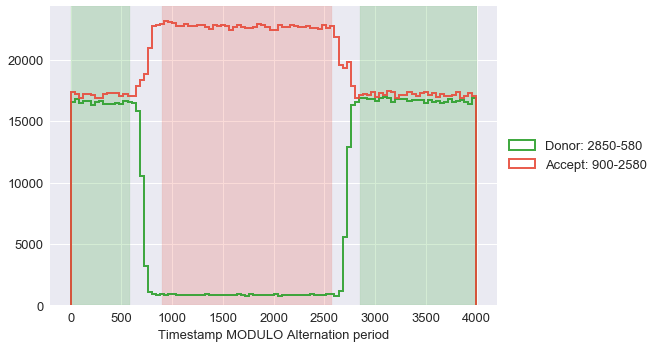

In [16]:
plot_alternation_hist(d)

If the plot looks good we can apply the parameters with:

In [17]:
loader.alex_apply_period(d)

# Total photons (after ALEX selection):   2,453,382
#  D  photons in D+A excitation periods:    756,184
#  A  photons in D+A excitation periods:  1,697,198
# D+A photons in  D  excitation period:   1,462,400
# D+A photons in  A  excitation period:     990,982



## Measurements infos

All the measurement data is in the `d` variable. We can print it:

In [18]:
d

singlespot_004_dsDNA_17d_green100u_red40u G1.000 Lk10.029 dir6.1

Or check the **measurements duration**:

In [19]:
d.time_max

600.00559991249997

## Compute background

Compute the background using automatic threshold:

In [20]:
d.calc_bg(bg.exp_fit, time_s=60, tail_min_us='auto', F_bg=1.7)

 - Calculating BG rates ... 

[DONE]


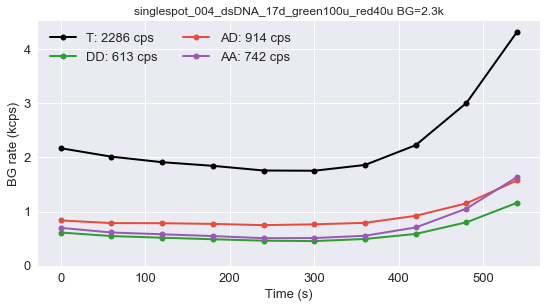

In [21]:
dplot(d, timetrace_bg)

In [22]:
d.rate_m, d.rate_dd, d.rate_ad, d.rate_aa

([2286.0248813678868],
 [613.94010117705795],
 [914.22216629179422],
 [742.22554889663013])

# Burst search and selection

In [23]:
d.burst_search(L=10, m=10, F=7, ph_sel=Ph_sel('all'))

 - Performing burst search (verbose=False) ...

[DONE]


 - Calculating burst periods ...

[DONE]


 - Counting D and A ph and calculating FRET ... 


   - Applying background correction.


   - Applying leakage correction.


   - Applying direct excitation correction.


   [DONE Counting D/A]


all


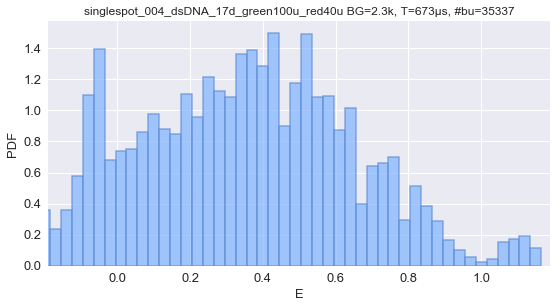

In [24]:
print(d.ph_sel)
dplot(d, hist_fret);

In [25]:
# if data_id in ['7d', '27d']:
#     ds = d.select_bursts(select_bursts.size, th1=20)
# else:
#     ds = d.select_bursts(select_bursts.size, th1=30)

In [26]:
ds = d.select_bursts(select_bursts.size, add_naa=False, th1=30)

In [27]:
n_bursts_all = ds.num_bursts[0]

In [28]:
def select_and_plot_ES(fret_sel, do_sel):
    ds_fret= ds.select_bursts(select_bursts.ES, **fret_sel)
    ds_do = ds.select_bursts(select_bursts.ES, **do_sel)
    bpl.plot_ES_selection(ax, **fret_sel)
    bpl.plot_ES_selection(ax, **do_sel)    
    return ds_fret, ds_do

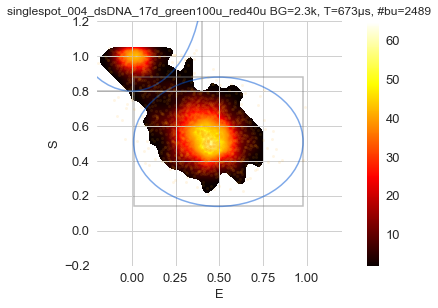

In [29]:
ax = dplot(ds, hist2d_alex, S_max_norm=2, scatter_alpha=0.1)

if data_id == '7d':
    fret_sel = dict(E1=0.60, E2=1.2, S1=0.2, S2=0.9, rect=False)
    do_sel = dict(E1=-0.2, E2=0.5, S1=0.8, S2=2, rect=True)    
    ds_fret, ds_do = select_and_plot_ES(fret_sel, do_sel)
    
elif data_id == '12d':
    fret_sel = dict(E1=0.30,E2=1.2,S1=0.131,S2=0.9, rect=False)
    do_sel = dict(E1=-0.4, E2=0.4, S1=0.8, S2=2, rect=False)
    ds_fret, ds_do = select_and_plot_ES(fret_sel, do_sel)

elif data_id == '17d':
    fret_sel = dict(E1=0.01, E2=0.98, S1=0.14, S2=0.88, rect=False)
    do_sel = dict(E1=-0.4, E2=0.4, S1=0.80, S2=2, rect=False)
    ds_fret, ds_do = select_and_plot_ES(fret_sel, do_sel)

elif data_id == '22d':
    fret_sel = dict(E1=-0.16, E2=0.6, S1=0.2, S2=0.80, rect=False)
    do_sel = dict(E1=-0.2, E2=0.4, S1=0.85, S2=2, rect=True)
    ds_fret, ds_do = select_and_plot_ES(fret_sel, do_sel)    

elif data_id == '27d':
    fret_sel = dict(E1=-0.1, E2=0.5, S1=0.2, S2=0.82, rect=False)
    do_sel = dict(E1=-0.2, E2=0.4, S1=0.88, S2=2, rect=True)
    ds_fret, ds_do = select_and_plot_ES(fret_sel, do_sel)    

In [30]:
n_bursts_do = ds_do.num_bursts[0]
n_bursts_fret = ds_fret.num_bursts[0]

n_bursts_do, n_bursts_fret

(463, 1964)

In [31]:
d_only_frac = 1.*n_bursts_do/(n_bursts_do + n_bursts_fret)
print('D-only fraction:', d_only_frac)

D-only fraction: 0.190770498558


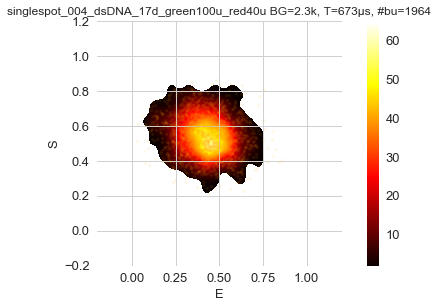

In [32]:
dplot(ds_fret, hist2d_alex, scatter_alpha=0.1);

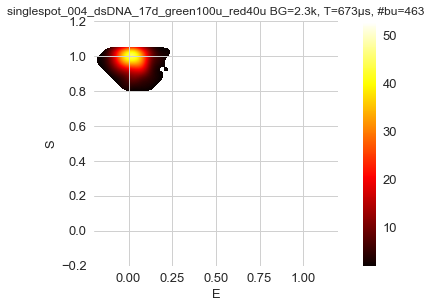

In [33]:
dplot(ds_do, hist2d_alex, S_max_norm=2, scatter=False);

# Donor Leakage fit

In [34]:
bandwidth = 0.03

E_range_do = (-0.1, 0.15)
E_ax = np.r_[-0.2:0.401:0.0002]

E_pr_do_kde = bext.fit_bursts_kde_peak(ds_do, bandwidth=bandwidth, weights='size', 
                                       x_range=E_range_do, x_ax=E_ax, save_fitter=True)

all: E_peak = 1.28%


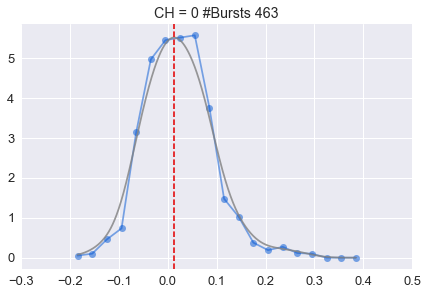

In [35]:
mfit.plot_mfit(ds_do.E_fitter, plot_kde=True, bins=np.r_[E_ax.min(): E_ax.max(): bandwidth])
plt.xlim(-0.3, 0.5)
print("%s: E_peak = %.2f%%" % (ds.ph_sel, E_pr_do_kde*100))

# Burst sizes

In [36]:
nt_th1 = 50

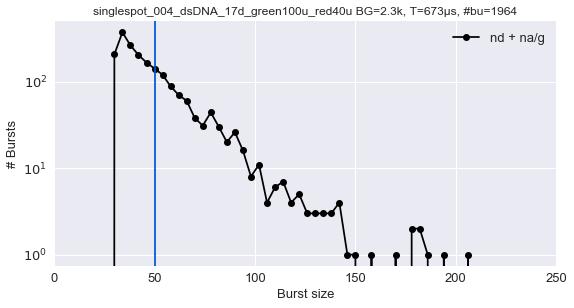

In [37]:
dplot(ds_fret, hist_size, which='all', add_naa=False)
xlim(-0, 250)
plt.axvline(nt_th1)

In [38]:
Th_nt = np.arange(35, 120)
nt_th = np.zeros(Th_nt.size)
for i, th in enumerate(Th_nt):
    ds_nt = ds_fret.select_bursts(select_bursts.size, th1=th)
    nt_th[i] = (ds_nt.nd[0]  + ds_nt.na[0]).mean() - th

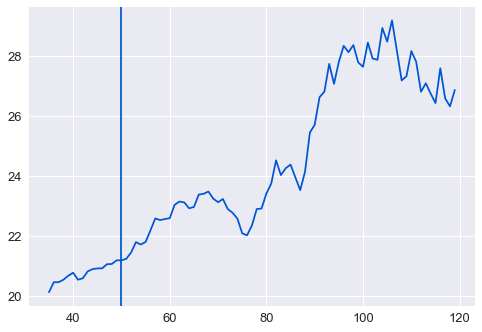

In [39]:
plt.figure()
plot(Th_nt, nt_th)
plt.axvline(nt_th1)

In [40]:
nt_mean = nt_th[np.where(Th_nt == nt_th1)][0]
nt_mean

21.193170874766935

# Fret fit

Max position of the Kernel Density Estimation (KDE):

In [41]:
E_pr_fret_kde = bext.fit_bursts_kde_peak(ds_fret, bandwidth=bandwidth, weights='size')
E_fitter = ds_fret.E_fitter

In [42]:
E_fitter.histogram(bins=np.r_[-0.1:1.1:0.03])

In [43]:
E_fitter.fit_histogram(mfit.factory_gaussian(), center=0.5)

all
KDE peak 43.20 


,amplitude,center,sigma
0,98.6312,42.7114,11.3675


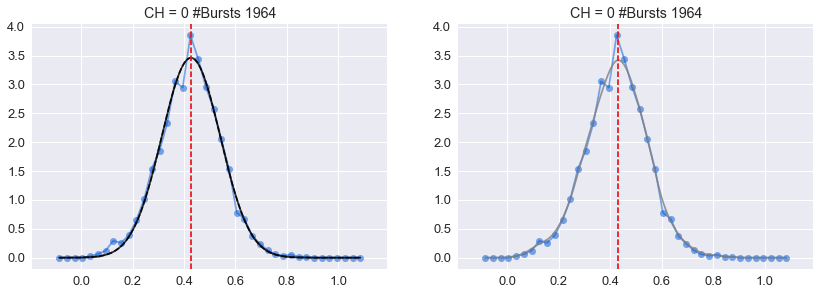

In [44]:
fig, ax = plt.subplots(1, 2, figsize=(14, 4.5))
mfit.plot_mfit(E_fitter, ax=ax[0])
mfit.plot_mfit(E_fitter, plot_model=False, plot_kde=True, ax=ax[1])
print('%s\nKDE peak %.2f ' % (ds_fret.ph_sel, E_pr_fret_kde*100))
display(E_fitter.params*100)

Weighted mean of $E$ of each burst:

In [45]:
ds_fret.fit_E_m(weights='size')

array([ 0.42396018])

Gaussian fit (no weights):

In [46]:
ds_fret.fit_E_generic(fit_fun=bl.gaussian_fit_hist, bins=np.r_[-0.1:1.1:0.03], weights=None)

array([ 0.42639952])

Gaussian fit (using burst size as weights):

In [47]:
ds_fret.fit_E_generic(fit_fun=bl.gaussian_fit_hist, bins=np.r_[-0.1:1.1:0.005], weights='size')

array([ 0.42775404])

In [48]:
E_kde_w = E_fitter.kde_max_pos[0]
E_gauss_w = E_fitter.params.loc[0, 'center']
E_gauss_w_sig = E_fitter.params.loc[0, 'sigma']
E_gauss_w_err = float(E_gauss_w_sig/np.sqrt(ds_fret.num_bursts[0]))
E_kde_w, E_gauss_w, E_gauss_w_sig, E_gauss_w_err

(0.43200000000001809,
 0.42711449181031236,
 0.11367508065421683,
 0.0025650422873150077)

# Stoichiometry fit

Max position of the Kernel Density Estimation (KDE):

In [49]:
S_pr_fret_kde = bext.fit_bursts_kde_peak(ds_fret, burst_data='S', bandwidth=0.03) #weights='size', add_naa=True)
S_fitter = ds_fret.S_fitter

In [50]:
S_fitter.histogram(bins=np.r_[-0.1:1.1:0.03])
S_fitter.fit_histogram(mfit.factory_gaussian(), center=0.5)

all
KDE peak 54.34 


,amplitude,center,sigma
0,100.954,53.7124,11.2882


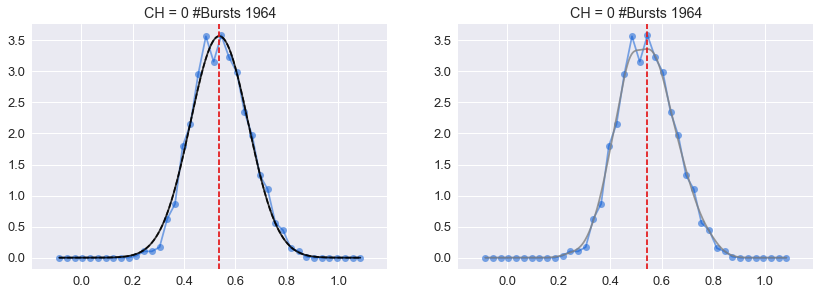

In [51]:
fig, ax = plt.subplots(1, 2, figsize=(14, 4.5))
mfit.plot_mfit(S_fitter, ax=ax[0])
mfit.plot_mfit(S_fitter, plot_model=False, plot_kde=True, ax=ax[1])
print('%s\nKDE peak %.2f ' % (ds_fret.ph_sel, S_pr_fret_kde*100))
display(S_fitter.params*100)

In [52]:
S_kde = S_fitter.kde_max_pos[0]
S_gauss = S_fitter.params.loc[0, 'center']
S_gauss_sig = S_fitter.params.loc[0, 'sigma']
S_gauss_err = float(S_gauss_sig/np.sqrt(ds_fret.num_bursts[0]))
S_kde, S_gauss, S_gauss_sig, S_gauss_err

(0.5434000000000212, 0.5371236796673191, 0.1128823145590383, 0.002547153770796)

The Maximum likelihood fit for a Gaussian population is the mean:

In [53]:
S = ds_fret.S[0]
S_ml_fit = (S.mean(), S.std())
S_ml_fit

(0.54237569169874122, 0.10814373467241754)

Computing the weighted mean and weighted standard deviation we get:

In [54]:
weights = bl.fret_fit.get_weights(ds_fret.nd[0], ds_fret.na[0], weights='size', naa=ds_fret.naa[0], gamma=1.)
S_mean = np.dot(weights, S)/weights.sum()
S_std_dev = np.sqrt(
        np.dot(weights, (S - S_mean)**2)/weights.sum())
S_wmean_fit = [S_mean, S_std_dev]
S_wmean_fit

[0.52280481188055061, 0.10479140996848577]

# Save data to file

In [55]:
sample = data_id

The following string contains the list of variables to be saved. When saving, the order of the variables is preserved.

In [56]:
variables = ('sample n_bursts_all n_bursts_do n_bursts_fret '
             'E_kde_w E_gauss_w E_gauss_w_sig E_gauss_w_err S_kde S_gauss S_gauss_sig S_gauss_err '
             'E_pr_do_kde nt_mean\n')

This is just a trick to format the different variables:

In [57]:
variables_csv = variables.replace(' ', ',')
fmt_float = '{%s:.6f}'
fmt_int = '{%s:d}'
fmt_str = '{%s}'
fmt_dict = {**{'sample': fmt_str}, 
            **{k: fmt_int for k in variables.split() if k.startswith('n_bursts')}}
var_dict = {name: eval(name) for name in variables.split()}
var_fmt = ', '.join([fmt_dict.get(name, fmt_float) % name for name in variables.split()]) + '\n'
data_str = var_fmt.format(**var_dict)

print(variables_csv)
print(data_str)

sample,n_bursts_all,n_bursts_do,n_bursts_fret,E_kde_w,E_gauss_w,E_gauss_w_sig,E_gauss_w_err,S_kde,S_gauss,S_gauss_sig,S_gauss_err,E_pr_do_kde,nt_mean

17d, 2489, 463, 1964, 0.432000, 0.427114, 0.113675, 0.002565, 0.543400, 0.537124, 0.112882, 0.002547, 0.012800, 21.193171



In [58]:
# NOTE: The file name should be the notebook name but with .csv extension
with open('results/usALEX-5samples-PR-leakage-dir-ex-all-ph.csv', 'a') as f:
    f.seek(0, 2)
    if f.tell() == 0:
        f.write(variables_csv)
    f.write(data_str)